# Installing prerequisites

In [ ]:
!pip install datasets

# Handling Imports

In [ ]:
import numpy as np
from google.colab.patches import PIL
import matplotlib.pyplot as plt

import time,os,copy,random,requests
from io import BytesIO

import torchvision,torch
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
from PIL import Image

from datasets import load_dataset
import json

from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

from PIL import Image
import requests
from io import BytesIO

# User defined functions

In [ ]:
def Modifier(input_image,pixel_mask):
    output_image=input_image.copy()
    output_pixel_mask = pixel_mask.copy()
    x = random.randrange(output_image.width)
    y = random.randrange(output_image.height)
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    output_image.putpixel((x,y),(r,g,b))
    output_pixel_mask.putpixel((x,y),(r,g,b))
    return output_image,output_pixel_mask


In [ ]:
output_directory = '/content/drive/MyDrive/colab_research_data/run'
def write_list(a_list,path):
    print("Started writing list data into a json file")
    with open(path, "w") as fp:
        json.dump(a_list, fp)
        print("Done writing JSON data into .json file")

def read_list(path):
    # for reading also binary mode is important
    with open(path, 'rb') as fp:
        n_list = json.load(fp)
        return n_list

# Loading dataset from huggingface

In [ ]:
dataset = load_dataset("jamescalam/unsplash-25k-photos")

3 514 2050 87 1623


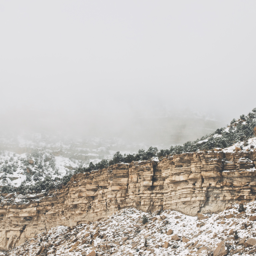

In [ ]:
url = dataset['train'][2]['photo_image_url']
response = requests.get(url)
img = Image.open(BytesIO(response.content))

width, height = img.size
m = min(width,height)
whole = int(m/256)
available_image = int(whole/2)
 
# Setting the points for cropped image
left = int(width/2)-256*available_image
top = int(height/2)-256*available_image
right = int(width/2)+256*available_image
bottom = int(height/2)+256*available_image

print(available_image,left,right,top,bottom)
 
# Cropped image of above dimension
# (It will not change original image)
im1 = img.crop((left, top, right, bottom)).resize((256,256))
display(im1)

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparation
### Going though the dataset and collecting images with more than 50% confidence in predictions and storing the list on google drive for later comsumption  

In [ ]:
good_images = []
json_filepath = '/content/drive/MyDrive/colab_research_data/good_images.json'
for i in range(len(dataset['train'])):
  try:
    url = dataset['train'][i]['photo_image_url']
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    width, height = img.size
    m = min(width,height)
    whole = int(m/256)
    available_image = int(whole/2)
    
    # Setting the points for cropped image
    left = int(width/2)-256*available_image
    top = int(height/2)-256*available_image
    right = int(width/2)+256*available_image
    bottom = int(height/2)+256*available_image

    
    # Cropped image of above dimension
    # (It will not change original image)
    im1 = img.crop((left, top, right, bottom)).resize((256,256)).convert('RGB')

    # Step 1: Initialize model with the best available weights
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model.eval()

    # Step 2: Initialize the inference transforms
    preprocess = weights.transforms()
    img = F.to_tensor(im1)

    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(img).unsqueeze(0)

    # Step 4: Use the model and print the predicted category
    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    if(score > 0.5):
      print(f"{category_name}: {100 * score:.1f}%")
      good_images.append([i,score,category_name])
      write_list(good_images,json_filepath)
  except:
    print("Something else went wrong")

# Current

In [ ]:
processes_dataset_file = read_list(json_filepath)

In [ ]:
for processed_dataset in processes_dataset_file[:1]:
    url = dataset['train'][processed_dataset[0]]['photo_image_url']
    prediction_score = processed_dataset[1]
    prediction_category = processed_dataset[2]
    testing_url = url
    print('{0} : {1} : {2}'.format(url,prediction_score,prediction_category))


In [ ]:
main_file_content = []
for i,processed_dataset in enumerate(processes_dataset_file[:100]):
    url = dataset['train'][processed_dataset[0]]['photo_image_url']

    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    width, height = img.size
    m = min(width,height)
    whole = int(m/256)
    available_image = int(whole/2)

    # Setting the points for cropped image
    left = int(width/2)-256*available_image
    top = int(height/2)-256*available_image
    right = int(width/2)+256*available_image
    bottom = int(height/2)+256*available_image


    # Cropped image of above dimension
    im1 = img.crop((left, top, right, bottom)).resize((256,256)).convert('RGB')
    og_image = im1

    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model.eval()

    # Step 2: Initialize the inference transforms
    preprocess = weights.transforms()

    top_predictions_dict = {}
    initial_predictions_dict = {}

    tensor_img = F.to_tensor(og_image)
    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(tensor_img).unsqueeze(0)

    # Step 4: Use the model and print the predicted category
    prediction = model(batch).squeeze(0).softmax(0)


    predictions = prediction.argsort()[-3:]
    for class_id in predictions:
      score = prediction[class_id].item()
      category_name = weights.meta["categories"][class_id]
      print(f"class_id:{class_id}   category_name:{category_name}  score:{100 * score:.1f}%")
      initial_predictions_dict[category_name] = score

    last_predictions_dict = initial_predictions_dict.copy()

    predicted_category = list(initial_predictions_dict)[2]
    to_be_predicted_category = list(initial_predictions_dict)[1]

    print(predicted_category)
    print(to_be_predicted_category)

    # we start with copying original image to modified buffer
    modified_image = og_image.copy()
    final_img = None
    pixel_mask = PIL.Image.new(mode="RGB", size=(256, 256))
    pixels_modified = 0
    while(True):
      new_image,new_pixel_mask = Modifier(modified_image,pixel_mask)
      tensor_image = F.to_tensor(new_image)

      # Step 3: Apply inference preprocessing transforms
      batch = preprocess(tensor_image).unsqueeze(0)

      # Step 4: Use the model and print the predicted category
      prediction = model(batch).squeeze(0).softmax(0)
      top_predictions = prediction.argsort()[-3:]
      current_prediction = {}
      for class_id in top_predictions:
        score = prediction[class_id].item()
        category_name = weights.meta["categories"][class_id]
        current_prediction[category_name] = score

      # If both categories are present 
      if to_be_predicted_category in current_prediction and predicted_category in current_prediction:

        # If we made improvement on the 2nd best category but we made improvement in modifying the prediction
        if current_prediction[to_be_predicted_category] > last_predictions_dict[to_be_predicted_category]:
          last_predictions_dict = current_prediction.copy()
          modified_image = new_image
          pixel_mask = new_pixel_mask
          pixels_modified += 1
          print(".",end = '')

        # if desired scenario is reached, 2nd category is greater than 1st category's initial prediction
        if current_prediction[to_be_predicted_category] > initial_predictions_dict[predicted_category]:
          result = current_prediction.copy()
          result['pixels_modified'] = pixels_modified
          result['img'] = "{}_original.jpeg".format(i)
          result['pixel_mask'] = "{}_pixel.jpeg".format(i)
          result['final_img'] = "{}_modified.jpeg".format(i)
          result['initial_confidence_primary'] = initial_predictions_dict[predicted_category]
          result['initial_confidence_secondary'] = initial_predictions_dict[to_be_predicted_category]
          result['predicted_category'] = predicted_category
          result['to_be_predicted_category'] = to_be_predicted_category
          
          #for debugging
          print(result)

          #appending main result
          main_file_content.append(result)

          # Writing the results to google drive
          write_list(result,os.path.join(output_directory,"{}_data.json".format(i)))
          og_image.save(os.path.join(output_directory,"{}_original.jpeg".format(i)))
          pixel_mask.save(os.path.join(output_directory,"{}_pixel.jpeg".format(i)))
          modified_image.save(os.path.join(output_directory,"{}_modified.jpeg".format(i)))
          write_list(main_file_content,os.path.join(output_directory,"main.json"))
          break

      # If the leading category is not even there on the predictions anymore, exiting;
      if predicted_category not in current_prediction and to_be_predicted_category not in current_prediction:
        break
